In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

latent_dim = 20         # size of z, smaller=more compression
batch_size = 128
lr = 1e-3
num_epochs = 20
img_channels = 1        # MNIST grayscale
img_size = 28

Device: cuda


In [6]:
#Data loaders
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.56MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.86MB/s]


In [7]:
#VAE model (Conv encoder + ConvTranspose decoder)
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Encoder: conv -> downsample -> flatten -> linear to mu/logvar
        self.enc_conv = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1),  # 28x28 -> 14x14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),            # 14x14 -> 7x7
            nn.ReLU(True),
            nn.Flatten()
        )
        enc_out_dim = 64 * 7 * 7
        self.fc_mu    = nn.Linear(enc_out_dim, latent_dim)
        self.fc_logvar= nn.Linear(enc_out_dim, latent_dim)

        # Decoder: linear from z -> feature map -> convtranspose upsampling -> sigmoid output
        self.fc_decode = nn.Linear(latent_dim, enc_out_dim)
        self.dec_conv = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 7x7 -> 14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1), # 14x14 -> 28x28
            nn.Sigmoid()  # output in [0,1] to match input
        )

    def encode(self, x):
        h = self.enc_conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # z = mu + sigma * eps  (reparameterization trick)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = self.fc_decode(z)
        x_recon = self.dec_conv(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [10]:
#Instantiate model + optimizer
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
#Loss function: Reconstruction (BCE) + KL divergence
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss: sum over pixels (binary cross-entropy)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence between q(z|x) and N(0,1)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [12]:
#Training loop
model.train()
for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    train_bce = 0.0
    train_kld = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce  = train_bce / len(train_loader.dataset)
    avg_kld  = train_kld / len(train_loader.dataset)
    print(f"Epoch {epoch:2d}  Avg loss: {avg_loss:.4f}  BCE: {avg_bce:.4f}  KLD: {avg_kld:.4f}")

Epoch  1  Avg loss: 155.2164  BCE: 133.3020  KLD: 21.9144
Epoch  2  Avg loss: 114.3847  BCE: 88.0250  KLD: 26.3597
Epoch  3  Avg loss: 109.6853  BCE: 83.3974  KLD: 26.2879
Epoch  4  Avg loss: 107.5424  BCE: 81.3688  KLD: 26.1736
Epoch  5  Avg loss: 106.2402  BCE: 80.1216  KLD: 26.1186
Epoch  6  Avg loss: 105.2919  BCE: 79.2010  KLD: 26.0910
Epoch  7  Avg loss: 104.5713  BCE: 78.5414  KLD: 26.0299
Epoch  8  Avg loss: 103.9398  BCE: 77.9729  KLD: 25.9669
Epoch  9  Avg loss: 103.4979  BCE: 77.5364  KLD: 25.9615
Epoch 10  Avg loss: 103.0579  BCE: 77.1652  KLD: 25.8927
Epoch 11  Avg loss: 102.6902  BCE: 76.8307  KLD: 25.8595
Epoch 12  Avg loss: 102.3954  BCE: 76.5588  KLD: 25.8366
Epoch 13  Avg loss: 102.1065  BCE: 76.2898  KLD: 25.8167
Epoch 14  Avg loss: 101.8178  BCE: 76.0713  KLD: 25.7464
Epoch 15  Avg loss: 101.6206  BCE: 75.8820  KLD: 25.7386
Epoch 16  Avg loss: 101.3856  BCE: 75.6826  KLD: 25.7031
Epoch 17  Avg loss: 101.2032  BCE: 75.5137  KLD: 25.6895
Epoch 18  Avg loss: 100.9775  

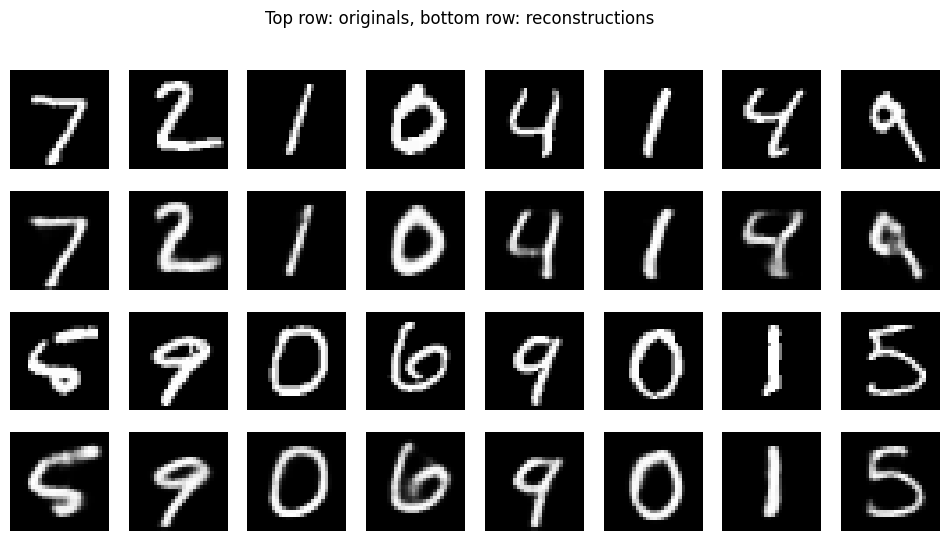

In [13]:
#Visualize reconstructions (take first batch from test set)
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, mu, logvar = model(data[:16])
    recon = recon.cpu()
    orig = data[:16].cpu()

# plot originals and reconstructions side-by-side
fig, axes = plt.subplots(4, 8, figsize=(12,6))
for i in range(8):
    axes[0, i].imshow(orig[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

for i in range(8,16):
    axes[2, i-8].imshow(orig[i].squeeze(), cmap='gray')
    axes[2, i-8].axis('off')
    axes[3, i-8].imshow(recon[i].squeeze(), cmap='gray')
    axes[3, i-8].axis('off')
plt.suptitle("Top row: originals, bottom row: reconstructions")
plt.show()

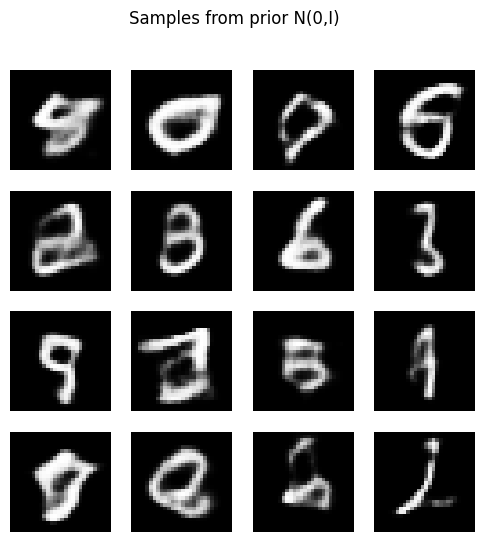

In [14]:
#Sample new images (sample z ~ N(0,I) and decode)
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = model.decode(z).cpu()

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle("Samples from prior N(0,I)")
plt.show()

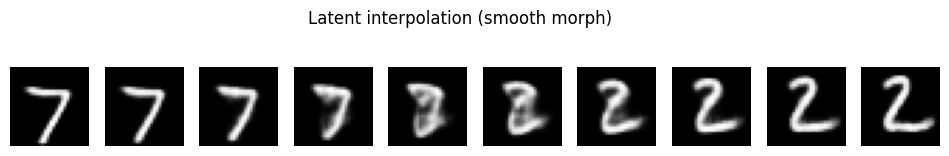

In [15]:
#Latent interpolation between two test images
def interpolate(a, b, steps=8):
    # a,b are image tensors (1,1,28,28) on cpu
    model.eval()
    with torch.no_grad():
        mu_a, logvar_a = model.encode(a.to(device))
        mu_b, logvar_b = model.encode(b.to(device))
        # use means (or sample) for interpolation
        z_a = mu_a
        z_b = mu_b
        grid = []
        for alpha in np.linspace(0, 1, steps):
            z = (1-alpha) * z_a + alpha * z_b
            x = model.decode(z).cpu()
            grid.append(x.squeeze().numpy())
    return grid

a = test_dataset[0][0].unsqueeze(0)  # choose any two MNIST images
b = test_dataset[1][0].unsqueeze(0)
grid = interpolate(a, b, steps=10)
fig, axs = plt.subplots(1, 10, figsize=(12,2))
for i in range(10):
    axs[i].imshow(grid[i], cmap='gray'); axs[i].axis('off')
plt.suptitle("Latent interpolation (smooth morph)")
plt.show()
